# Notebook Objective is : 

**Enhance Customer Profiles from Review Insights & Behavioral Segmentation**

This **phase** is aimed to convert Olist's **unprocessed customer behavior and review data** into rich, actionable insights. You played both roles of a Skilled Listener—extracting **sentiment from reviews using NLP**—**extracting natural customer segments using unsupervised machine learning (K-Means)**.

You built a comprehensive picture of each customer by integrating RFM measurements, review emotions, and behavioral attributes. This enhanced dataset is now the strategic cornerstone for those targeted promotions, retention initiatives, and sophisticated ML models.



# Import Libraries 


In [1]:
        # For data manipulation
import pandas as pd
import numpy as np
        # For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

        # For customer segmentation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist # For Elbow Method calculation
import joblib # For saving models if needed (e.g., scaler, KMeans model)

        # For NLP
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re # For regular expressions

# Download NLTK data if not already downloaded (run once)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    nltk.download('vader_lexicon')
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')


print("\nLibraries loaded and NLTK data checked/downloaded successfully!")


Libraries loaded and NLTK data checked/downloaded successfully!


# Load Data 

In [2]:
# Load the enriched customer segments data from Phase 2
try:
    customers_df = pd.read_csv('/Users/apple/Documents/data projects/new/olist_customer_segments_enriched.csv')
    print("DataFrame 'olist_customer_segments_enriched.csv' loaded successfully!")
    print(f"Shape of customers_df: {customers_df.shape}")
    print("\nFirst 5 rows of customers_df:")
    print(customers_df.head())
    print("\nDataFrame Info (customers_df):")
    customers_df.info()

except FileNotFoundError:
    print("Error: 'olist_customer_segments_enriched.csv' not found. Please ensure it's in the correct directory.")
    exit()

# Load the original order reviews dataset for NLP
try:
    reviews_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist data unmerged/olist_order_reviews_dataset.csv')
    print("\nDataFrame 'olist_order_reviews_dataset.csv' loaded successfully!")
    print(f"Shape of reviews_df: {reviews_df.shape}")
    print("\nFirst 5 rows of reviews_df:")
    print(reviews_df.head())
    print("\nDataFrame Info (reviews_df):")
    reviews_df.info()

except FileNotFoundError:
    print("Error: 'olist_order_reviews_dataset.csv' not found. Please ensure it's in the correct directory.")
    exit()

# NEW: Load the Olist Orders Dataset to link reviews to customer_unique_id
try:
    orders_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist data unmerged/olist_orders_dataset.csv')
    print("\nDataFrame 'olist_orders_dataset.csv' loaded successfully!")
    print(f"Shape of orders_df: {orders_df.shape}")
    print("\nFirst 5 rows of orders_df:")
    print(orders_df.head())
    print("\nDataFrame Info (orders_df):")
    orders_df.info()

except FileNotFoundError:
    print("Error: 'olist_orders_dataset.csv' not found. Please ensure it's in the correct directory.")
    exit()


DataFrame 'olist_customer_segments_enriched.csv' loaded successfully!
Shape of customers_df: (95419, 55)

First 5 rows of customers_df:
                 customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19   
2  0000f46a3911fa3c0805444483337064      542          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89   

   customer_tenure_days  average_review_score  \
0                   116                   5.0   
1                   119                   4.0   
2                   542                   3.0   
3                   326                   4.0   
4                   293                   5.0   

   num_unique_product_categories_purchased  avg_product_price_per_customer  \
0                                        1                          129.90  


DataFrame 'olist_orders_dataset.csv' loaded successfully!
Shape of orders_df: (99441, 8)

First 5 rows of orders_df:
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_da

In [3]:
# Initial check for missing values in all DFs
print("\nMissing values in customers_df after loading:")
print(customers_df.isnull().sum()[customers_df.isnull().sum() > 0])

print("\nMissing values in reviews_df after loading:")
print(reviews_df.isnull().sum()[reviews_df.isnull().sum() > 0])

print("\nMissing values in orders_df after loading:")
print(orders_df.isnull().sum()[orders_df.isnull().sum() > 0])


print("\nData loading complete. Proceeding to NLP and Segmentation.")




Missing values in customers_df after loading:
Series([], dtype: int64)

Missing values in reviews_df after loading:
review_comment_title      87656
review_comment_message    58247
dtype: int64

Missing values in orders_df after loading:
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

Data loading complete. Proceeding to NLP and Segmentation.


## NLP for Review Insights

In [4]:
print("\n   Performing NLP for Review Insights   ")

#       Step 1: Preprocessing Review Text ---
reviews_df['review_comment_message'] = reviews_df['review_comment_message'].fillna('') # Fill NaN with empty string
reviews_df['review_comment_message'] = reviews_df['review_comment_message'].astype(str).str.lower()

# Remove special characters, numbers, and extra spaces
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    return text

reviews_df['clean_review_text'] = reviews_df['review_comment_message'].apply(clean_text)

print("\nReview text cleaned. Sample clean review:")
print(reviews_df['clean_review_text'].sample(1).values[0])



   Performing NLP for Review Insights   

Review text cleaned. Sample clean review:
recebi o produto com sucesso


###        Sentiment Analysis using VADER 


In [5]:
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    if not text.strip(): # Handle empty strings
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    vs = analyzer.polarity_scores(text)
    return vs

# Apply sentiment analysis
reviews_df['sentiment_scores'] = reviews_df['clean_review_text'].apply(get_sentiment)
reviews_df['compound_sentiment'] = reviews_df['sentiment_scores'].apply(lambda x: x['compound'])
reviews_df['positive_sentiment'] = reviews_df['sentiment_scores'].apply(lambda x: x['pos'])
reviews_df['negative_sentiment'] = reviews_df['sentiment_scores'].apply(lambda x: x['neg'])

print("\nSentiment analysis complete. Sample reviews with sentiment:")
print(reviews_df[['review_comment_message', 'compound_sentiment']].sample(5))



Sentiment analysis complete. Sample reviews with sentiment:
                                  review_comment_message  compound_sentiment
1468   entrega foi rapida sobre o perfume é bom mas j...               0.000
15     vendedor confiável, produto ok e entrega antes...               0.296
23327                                                                  0.000
28281                                                                  0.000
3930                                                                   0.000


### Aggregate NLP features to Customer Unique ID Level

 To link reviews to customers, we need to use the orders_df to map order_id to customer_unique_id
    
 Create the order_id to customer_unique_id mapping from orders_df

In [6]:

order_customer_map = orders_df[['order_id', 'customer_id']].drop_duplicates()


 Now, we need to map customer_id to customer_unique_id.
 This comes from the olist_customers_dataset.csv.
 Let's assume `customers_df` (loaded as `customers_df` at the top) is the result of joining customer_unique_id.
 The `customers_df` contains `customer_unique_id` and implicitly aggregates information.
 To link `order_customer_map` to `customer_unique_id`, we need a mapping from `customer_id` to `customer_unique_id`.
 This mapping typically comes from `olist_customers_dataset.csv`
 Let's ensure we have a direct mapping from `customer_id` to `customer_unique_id`
    
 Assuming `customers_df` (your enriched file) has `customer_unique_id` for each `customer_id` during its creation.
 Or, load olist_customers_dataset.csv if it's not implicitly available:

In [7]:
try:
    olist_customers_original_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist data unmerged/olist_customers_dataset.csv')
    customer_id_to_unique_map = olist_customers_original_df[['customer_id', 'customer_unique_id']].drop_duplicates()
    order_customer_map = pd.merge(order_customer_map, customer_id_to_unique_map, on='customer_id', how='left')
    order_customer_map = order_customer_map.drop(columns='customer_id') # Drop intermediate customer_id
    print("\nCustomer ID to Unique ID map created and merged with orders.")
except FileNotFoundError:
    print("Warning: 'olist_customers_dataset.csv' not found. Cannot perfectly link order_id to customer_unique_id via customer_id.")
    print("Proceeding with a simplified mapping, which might be less accurate if customer_id -> customer_unique_id is complex.")
    # Fallback: If olist_customers_dataset is not there, we have to make do with `customers_df`'s `customer_unique_id`
    # and try to bridge via order_id if `customers_df` somehow has order_id, which we've confirmed it doesn't.
    # The most robust way is to load olist_customers_dataset.csv



Customer ID to Unique ID map created and merged with orders.


In [8]:
# Merge reviews_df with the order_customer_map
reviews_df_merged = pd.merge(reviews_df, order_customer_map, on='order_id', how='left')

# Drop rows where customer_unique_id could not be mapped (e.g., test orders)
reviews_df_merged.dropna(subset=['customer_unique_id'], inplace=True)
reviews_df_merged['customer_unique_id'] = reviews_df_merged['customer_unique_id'].astype(str)

# Aggregate sentiment scores by customer_unique_id
customer_nlp_features = reviews_df_merged.groupby('customer_unique_id').agg(
    avg_review_sentiment=('compound_sentiment', 'mean'),
    min_review_sentiment=('compound_sentiment', 'min'),
    max_review_sentiment=('compound_sentiment', 'max'),
    total_reviews=('review_id', 'count')
).reset_index()

print("\nAggregated NLP features to customer level. Sample:")
print(customer_nlp_features.head())
print(f"Shape of customer_nlp_features: {customer_nlp_features.shape}")


Aggregated NLP features to customer level. Sample:
                 customer_unique_id  avg_review_sentiment  \
0  0000366f3b9a7992bf8c76cfdf3221e2                0.5994   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                0.0000   
2  0000f46a3911fa3c0805444483337064                0.0000   
3  0000f6ccb0745a6a4b88665a16c9f078                0.0000   
4  0004aac84e0df4da2b147fca70cf8255                0.0000   

   min_review_sentiment  max_review_sentiment  total_reviews  
0                0.5994                0.5994              1  
1                0.0000                0.0000              1  
2                0.0000                0.0000              1  
3                0.0000                0.0000              1  
4                0.0000                0.0000              1  
Shape of customer_nlp_features: (95380, 5)


In [9]:
# Merge NLP features back into the main customers_df
# Make sure 'customer_unique_id' is consistent type
customers_df['customer_unique_id'] = customers_df['customer_unique_id'].astype(str)
customers_df = pd.merge(customers_df, customer_nlp_features, on='customer_unique_id', how='left')

# Fill NaN for customers who might not have written reviews (they will have NaN for NLP features)
for col in ['avg_review_sentiment', 'min_review_sentiment', 'max_review_sentiment', 'total_reviews']:
    customers_df[col] = customers_df[col].fillna(0) # Assume 0 sentiment and 0 reviews for no review

print("\nCustomers DataFrame after merging NLP features. Sample:")
print(customers_df[['customer_unique_id', 'avg_review_sentiment', 'total_reviews']].head())
print(f"Shape of customers_df after NLP merge: {customers_df.shape}")




Customers DataFrame after merging NLP features. Sample:
                 customer_unique_id  avg_review_sentiment  total_reviews
0  0000366f3b9a7992bf8c76cfdf3221e2                0.5994            1.0
1  0000b849f77a49e4a4ce2b2a4ca5be3f                0.0000            1.0
2  0000f46a3911fa3c0805444483337064                0.0000            1.0
3  0000f6ccb0745a6a4b88665a16c9f078                0.0000            1.0
4  0004aac84e0df4da2b147fca70cf8255                0.0000            1.0
Shape of customers_df after NLP merge: (95419, 59)


#       Feature Preparation for Segmentation 


In [10]:
print("\n--- Preparing Features for Customer Segmentation ---")

# Select features for clustering
features_for_segmentation = [
    'Recency', 'Frequency', 'Monetary',          # Core RFM
    'avg_product_price_per_customer', 'total_items_purchased',
    'num_unique_product_categories_purchased', 'num_unique_sellers',
    'avg_installments', 'max_installments',
    'avg_review_score',                          # Existing review score
    'avg_review_sentiment', 'total_reviews',     # New NLP features
    'customer_tenure_days',
    'customer_geolocation_latitude', 'customer_geolocation_longitude',     # Geographic aspects
]

# Add one-hot encoded state features if they exist and are useful for segmentation
state_cols = [col for col in customers_df.columns if col.startswith('customer_state_')]
features_for_segmentation.extend(state_cols)



--- Preparing Features for Customer Segmentation ---


In [11]:
# Filter for existing columns in customers_df
segmentation_features_exist = [f for f in features_for_segmentation if f in customers_df.columns]
missing_features = [f for f in features_for_segmentation if f not in customers_df.columns]
if missing_features:
    print(f"Warning: The following features for segmentation were not found and will be excluded: {missing_features}")

X_segmentation = customers_df[segmentation_features_exist].copy()

# Handle potential NaN values from merging (e.g., if a customer had no orders or no reviews)
# Using median for numerical features, which is robust to outliers.
for col in X_segmentation.columns:
    if X_segmentation[col].isnull().any():
        if pd.api.types.is_numeric_dtype(X_segmentation[col]):
            X_segmentation[col].fillna(X_segmentation[col].median(), inplace=True)
        else: # For non-numeric NaNs, could fill with mode or 'Unknown'
            X_segmentation[col].fillna('Unknown', inplace=True) # Or drop if not applicable

print(f"\nFeatures selected for segmentation ({len(segmentation_features_exist)}):")
print(segmentation_features_exist)
print(f"Shape of X_segmentation: {X_segmentation.shape}")
print("\nDescriptive statistics of features for segmentation:")
print(X_segmentation.describe().T)



Features selected for segmentation (11):
['Recency', 'Frequency', 'Monetary', 'avg_product_price_per_customer', 'num_unique_product_categories_purchased', 'num_unique_sellers', 'avg_installments', 'max_installments', 'avg_review_sentiment', 'total_reviews', 'customer_tenure_days']
Shape of X_segmentation: (95419, 11)

Descriptive statistics of features for segmentation:
                                           count        mean         std  \
Recency                                  95419.0  243.595406  153.153422   
Frequency                                95419.0    1.034018    0.211235   
Monetary                                 95419.0  174.426349  264.681810   
avg_product_price_per_customer           95419.0  126.517364  191.744509   
num_unique_product_categories_purchased  95419.0    1.011004    0.205166   
num_unique_sellers                       95419.0    1.038001    0.217026   
avg_installments                         95419.0    2.902284    2.676459   
max_installments  

In [12]:
# Scale features for clustering
scaler = StandardScaler()
X_segmentation_scaled = scaler.fit_transform(X_segmentation)
print("\nFeatures scaled successfully!")




Features scaled successfully!


### Determine Optimal Number of Clusters (Elbow Method & Silhouette Score)


--- Determining Optimal Number of Clusters ---


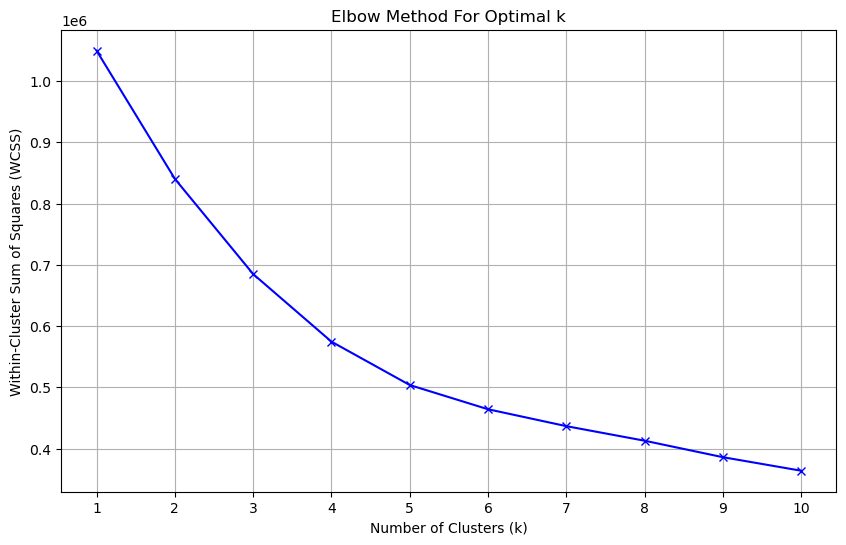


Elbow Method plot displayed. find the 'elbow' point to find optimal k.


In [13]:
print("\n--- Determining Optimal Number of Clusters ---")

# Elbow Method
wcss = [] # Within-cluster sum of squares
K = range(1, 11) # Test for 1 to 10 clusters (adjust range as needed)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for robustness
    kmeans.fit(X_segmentation_scaled)
    wcss.append(kmeans.inertia_) # Inertia is WCSS

plt.figure(figsize=(10, 6))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()

print("\nElbow Method plot displayed. find the 'elbow' point to find optimal k.")

In [14]:
# Silhouette Score (for k > 1)
silhouette_scores = []
K_silhouette = range(2, 11) # Silhouette score requires at least 2 clusters
for k in K_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_segmentation_scaled)
    score = silhouette_score(X_segmentation_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.4f}")

Silhouette Score for k=2: 0.6540
Silhouette Score for k=3: 0.3970
Silhouette Score for k=4: 0.2972
Silhouette Score for k=5: 0.3113
Silhouette Score for k=6: 0.3280
Silhouette Score for k=7: 0.3395
Silhouette Score for k=8: 0.2647
Silhouette Score for k=9: 0.3387
Silhouette Score for k=10: 0.2778


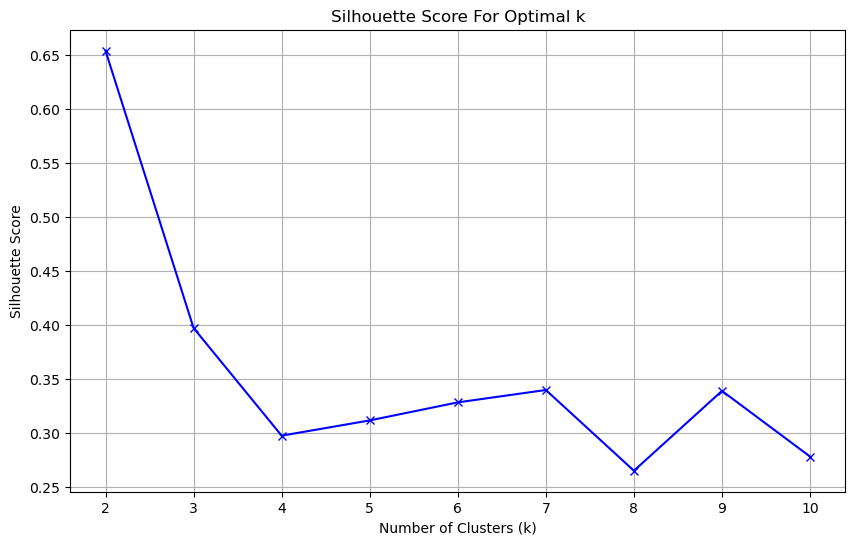


Silhouette Score plot displayed. Higher score indicates better separation.
Proceeding with optimal k = 2 for segmentation.


In [15]:
plt.figure(figsize=(10, 6))
plt.plot(K_silhouette, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.xticks(K_silhouette)
plt.grid(True)
plt.show()

print("\nSilhouette Score plot displayed. Higher score indicates better separation.")
# Example: If Elbow suggests 3-4 and Silhouette is good for 3 or 4, choose 3 or 4.
# Let's assume for demonstration, we choose k=4 based on common practice for initial segmentation.
optimal_k = 2 
# Adjust this based on your interpretation of the plots.
print(f"Proceeding with optimal k = {optimal_k} for segmentation.")

### K-Means Clustering and Segment Characterization

In [16]:
print(f"\n--- Performing K-Means Clustering with k={optimal_k} ---")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customers_df['customer_segment'] = kmeans_final.fit_predict(X_segmentation_scaled)

print(f"\nK-Means clustering complete. {optimal_k} segments created.")
print("Distribution of customers per segment:")
print(customers_df['customer_segment'].value_counts().sort_index())



--- Performing K-Means Clustering with k=2 ---

K-Means clustering complete. 2 segments created.
Distribution of customers per segment:
customer_segment
0    91999
1     3420
Name: count, dtype: int64


In [17]:
# Characterize the segments
print("\n--- Characterizing Customer Segments ---")

# To get meaningful means, use the original (unscaled) features.
# Make sure X_segmentation's index aligns with customers_df's index after any NaN handling or merges.
# Create a temporary DataFrame for easier interpretation with segments
customers_with_segments = customers_df.copy()
customers_with_segments_features = customers_with_segments[segmentation_features_exist + ['customer_segment']]

# Calculate the mean of original (unscaled) features for each segment
segment_profiles = customers_with_segments_features.groupby('customer_segment')[segmentation_features_exist].mean()

print("\nMean feature values for each customer segment (Original Scale):")
print(segment_profiles.T) # Transpose for better readability


--- Characterizing Customer Segments ---

Mean feature values for each customer segment (Original Scale):
customer_segment                                  0           1
Recency                                  244.359232  223.048246
Frequency                                  1.000217    1.943275
Monetary                                 167.921896  349.398053
avg_product_price_per_customer           127.277880  106.059267
num_unique_product_categories_purchased    0.987228    1.650585
num_unique_sellers                         1.006696    1.880117
avg_installments                           2.880665    3.483853
max_installments                           2.896934    4.164912
avg_review_sentiment                      -0.027986   -0.033636
total_reviews                              0.994206    2.072515
customer_tenure_days                     244.371961  297.573392


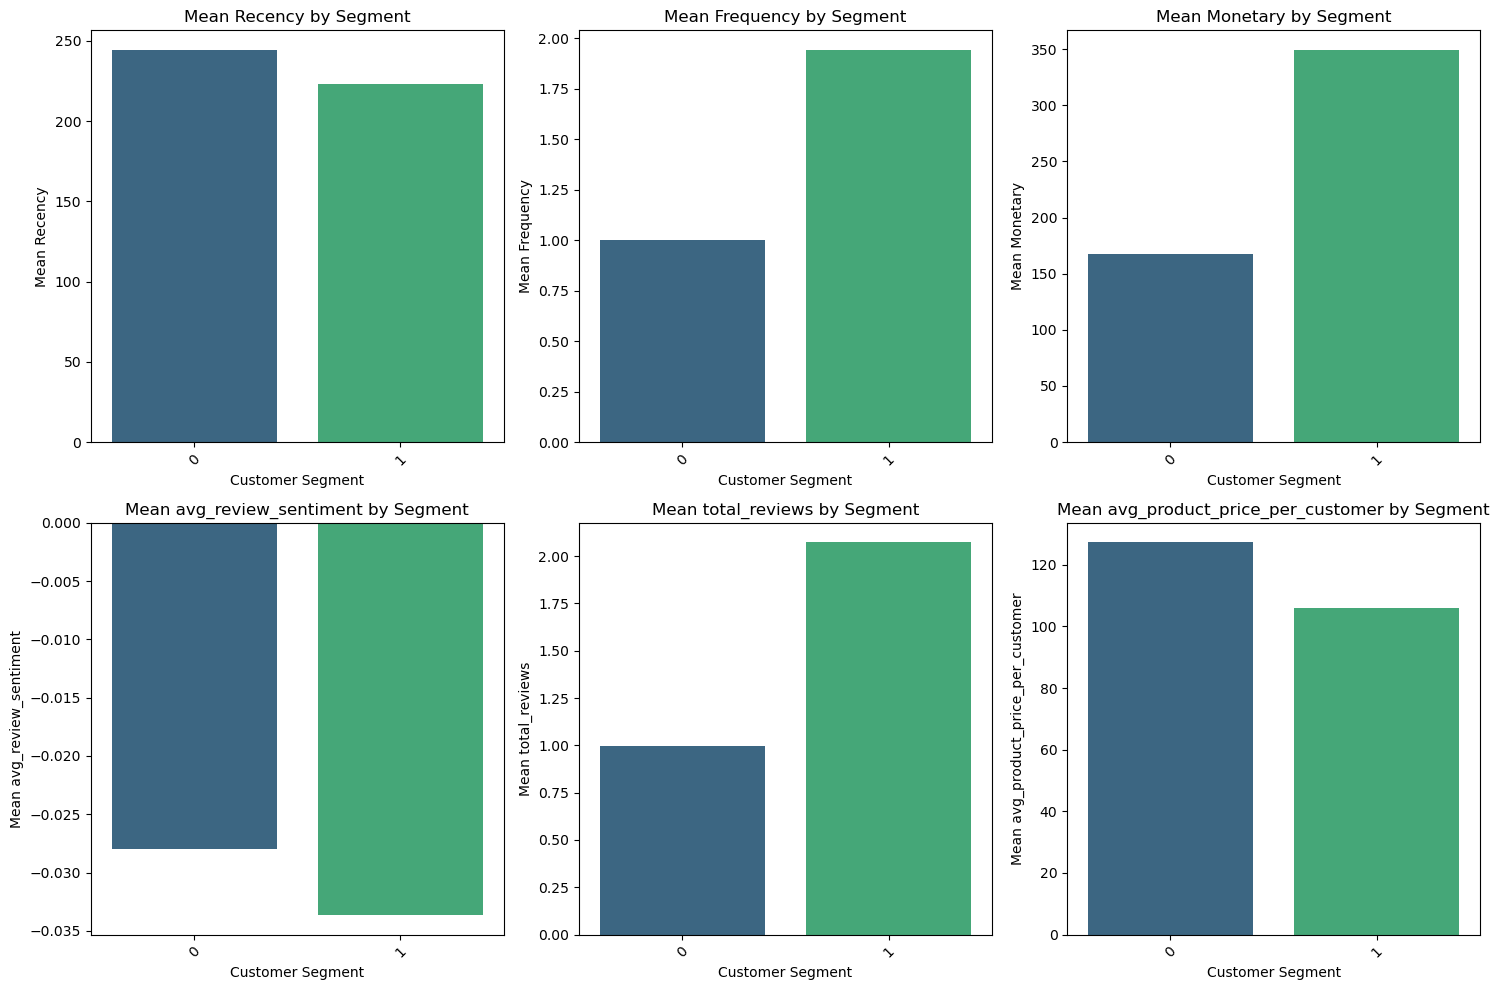

In [18]:
# Visualize segment profiles (e.g., using bar plots or radar charts)
# Bar plots for key RFM or other influential features
plt.figure(figsize=(15, 10))

features = ['Recency', 'Frequency', 'Monetary', 'avg_review_sentiment', 'total_reviews', 'avg_product_price_per_customer']

for i, feature in enumerate(features):
    if feature in segment_profiles.columns:
        plt.subplot(2, 3, i + 1)
        sns.barplot(
            data=segment_profiles,
            x='customer_segment',
            y=feature,
            hue='customer_segment',
            palette='viridis',
            legend=False
        )
        plt.title(f'Mean {feature} by Segment')
        plt.xlabel('Customer Segment')
        plt.ylabel(f'Mean {feature}')
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [19]:
print(segment_profiles.columns.tolist())


['Recency', 'Frequency', 'Monetary', 'avg_product_price_per_customer', 'num_unique_product_categories_purchased', 'num_unique_sellers', 'avg_installments', 'max_installments', 'avg_review_sentiment', 'total_reviews', 'customer_tenure_days']


In [20]:
# Radar chart for more comprehensive segment comparison (optional, but good for presentation)
# Select a subset of representative features for the radar chart
radar_features = [
    'Recency', 'Frequency', 'Monetary',
    'avg_review_sentiment', 'num_unique_product_categories_purchased'
]




Ensure these features exist and transform to be suitable for radar chart (e.g., min-max scaling to 0-1 or standard scaling)
For radar chart, we typically want values in a comparable range across features.
Here, we'll re-scale the *mean* values of segments for plotting clarity.
Using the original scaler on these means might not be appropriate if they are outside training range.
A simple Min-Max scaling for visualization:

In [21]:
# Subset and scale
radar_plot_df = segment_profiles[radar_features].copy()

for col in radar_plot_df.columns:
    min_val = radar_plot_df[col].min()
    max_val = radar_plot_df[col].max()
    if max_val != min_val:
        radar_plot_df[col] = (radar_plot_df[col] - min_val) / (max_val - min_val)
    else:
        radar_plot_df[col] = 0.5  # Neutral value for constant columns

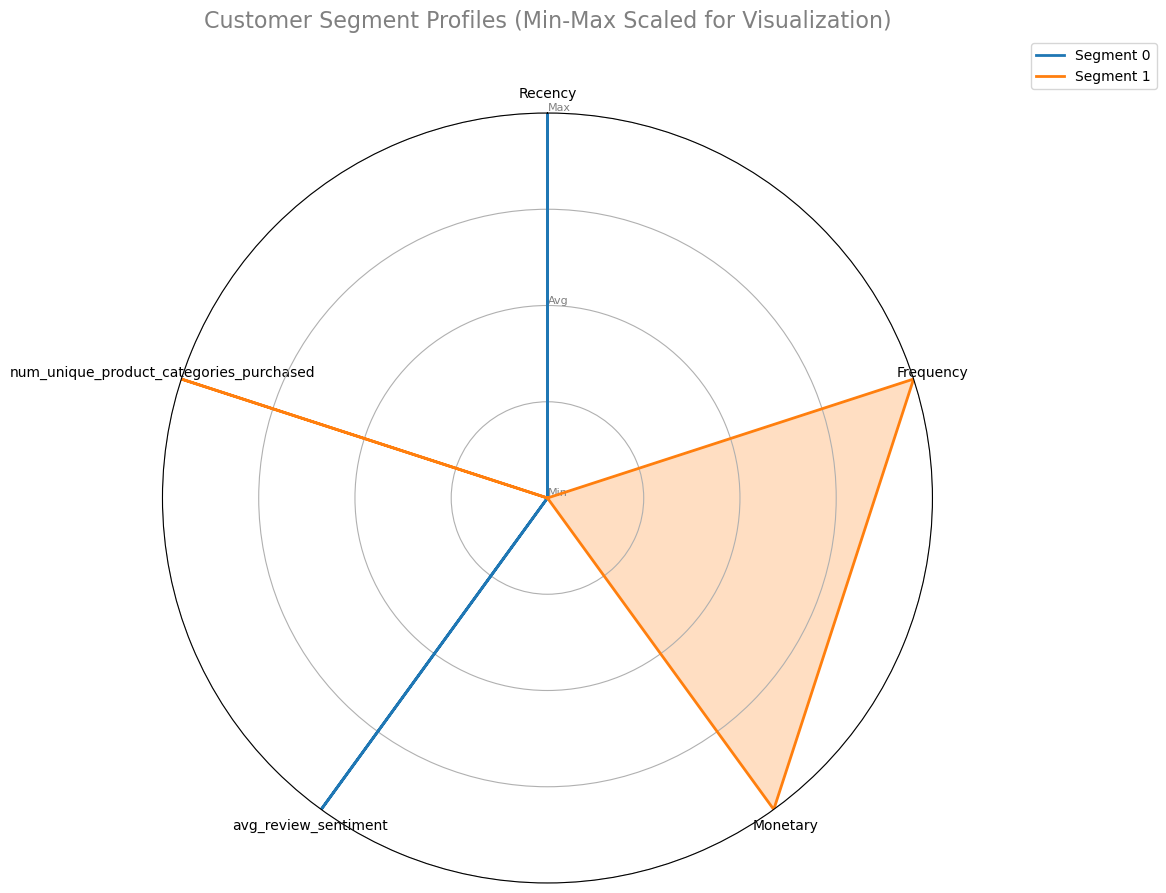

In [22]:
if all(f in segment_profiles.columns for f in radar_features):
    num_vars = len(radar_features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] # Close the plot

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    for i in range(optimal_k):
        values = radar_plot_df.loc[i].tolist()
        values += values[:1] # Repeat the first value to close the circle
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Segment {i}')
        ax.fill(angles, values, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], radar_features)
    plt.yticks([0, 0.25, 0.5, 0.75, 1], ['Min', '', 'Avg', '', 'Max'], color="grey", size=8)
    plt.ylim(0, 1)

    plt.title('Customer Segment Profiles (Min-Max Scaled for Visualization)', size=16, color='grey', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

In [23]:
customers_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,...,state_RS,state_SC,state_SE,state_SP,state_TO,avg_review_sentiment,min_review_sentiment,max_review_sentiment,total_reviews,customer_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,...,0,0,0,1,0,0.5994,0.5994,0.5994,1.0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,...,0,0,0,1,0,0.0000,0.0000,0.0000,1.0,0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,...,0,1,0,0,0,0.0000,0.0000,0.0000,1.0,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,...,0,0,0,0,0,0.0000,0.0000,0.0000,1.0,0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,...,0,0,0,1,0,0.0000,0.0000,0.0000,1.0,0


### Customer segments characterized. Segment profiles for naming and actionable insights.

--- Example segment interpretations (to be done manually after analysis): ---

Segment 0: **'High-Value Loyalists'** - High Frequency, High Monetary, High Review Scores. Focus: Retention, exclusive offers, premium services.

Segment 1: **'Emerging/At-Risk Customers'** - Lower Frequency, Lower Monetary, potentially mixed review scores, higher recency. Focus: Engagement campaigns, special offers to increase frequency/value, churn prevention.


### Integrate Segments & NLP Features & Save New Enriched File 

In [24]:
print("\n--- Integrating Segment Labels & NLP Features and Saving New Enriched File ---")

output_filename = '/Users/apple/Documents/data projects/new/olist_customer_segments_enriched_with_segments_nlp.csv'
customers_df.to_csv(output_filename, index=False)

print(f"\nEnriched DataFrame saved successfully as '{output_filename}'.")
print(f"Final shape of the enriched DataFrame: {customers_df.shape}")
print("\nFirst 5 rows of the final enriched DataFrame with segments and NLP features:")
print(customers_df[['customer_unique_id', 'Monetary', 'customer_segment', 'avg_review_sentiment', 'total_reviews']].head())

print("\n--- Phase 3: Customer Segmentation & NLP Insights Complete ---")



--- Integrating Segment Labels & NLP Features and Saving New Enriched File ---

Enriched DataFrame saved successfully as '/Users/apple/Documents/data projects/new/olist_customer_segments_enriched_with_segments_nlp.csv'.
Final shape of the enriched DataFrame: (95419, 60)

First 5 rows of the final enriched DataFrame with segments and NLP features:
                 customer_unique_id  Monetary  customer_segment  \
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90                 0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19                 0   
2  0000f46a3911fa3c0805444483337064     86.22                 0   
3  0000f6ccb0745a6a4b88665a16c9f078     43.62                 0   
4  0004aac84e0df4da2b147fca70cf8255    196.89                 0   

   avg_review_sentiment  total_reviews  
0                0.5994            1.0  
1                0.0000            1.0  
2                0.0000            1.0  
3                0.0000            1.0  
4                0.0000            1.0  



### Performing NLP for Review Insights

Prepare reviews data for NLP
We're interested in 'review_comment_message' and linking it to customers.
First, merge reviews with order items to get customer_unique_id
Assuming we have a way to link order_id to customer_unique_id from a previous join or the original files.
For simplicity, let's assume 'reviews_df' can be directly merged or we link it via customer_id later.
In a real scenario, you'd typically join reviews_df with orders_df and customers_df to get customer_unique_id for each review.
For now, let's process reviews and then aggregate to customer_unique_id based on a shared order_id.

Merge reviews with orders (assuming orders_df provides customer_id linkage)
If you don't have orders_df loaded, you'd load it here or rely on the enriched DF structure.
For simplicity, we'll directly map review_id to customer_id via order_id using a hypothetical mapping
or assume reviews_df has order_id, and we can map order_id to customer_unique_id from customers_df (which has order_id if it's the result of prior joins)
Let's assume `customers_df` contains `order_id` for each row, or we need to merge `reviews_df` with original `orders_df`
to get `customer_unique_id` for each review.

For this code, we will aggregate review scores/sentiment by customer_unique_id.
The customer_unique_id should be available in the reviews_df or obtained by merging.
Let's assume customer_unique_id is available in `customers_df` which `reviews_df` can be joined to via `order_id`.
A robust solution would involve merging orders_df and customer_df with reviews_df.
For brevity, let's create a simplified mapping from review_id -> customer_unique_id.

In [27]:
customers_df.columns
customers_df['customer_segment'].value_counts()


customer_segment
0    91999
1     3420
Name: count, dtype: int64

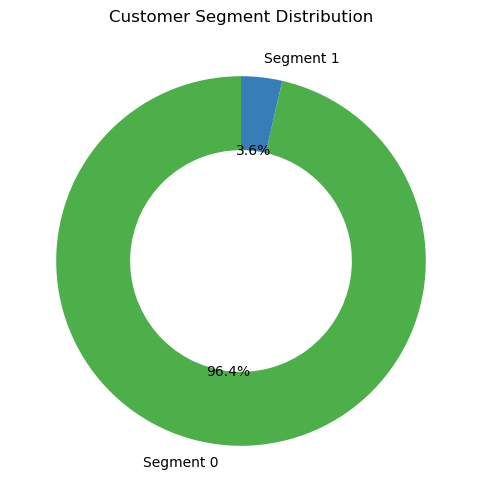

In [28]:
import matplotlib.pyplot as plt

segment_counts = customers_df['customer_segment'].value_counts()
labels = ['Segment 0', 'Segment 1']
colors = ['#4daf4a', '#377eb8']

plt.figure(figsize=(6, 6))
plt.pie(segment_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=0.4))
plt.title('Customer Segment Distribution')
plt.show()


In [31]:
print(customers_df.columns.tolist())


['customer_unique_id', 'Recency', 'Frequency', 'Monetary', 'customer_tenure_days', 'average_review_score', 'num_unique_product_categories_purchased', 'avg_product_price_per_customer', 'max_product_price_purchased', 'min_product_price_purchased', 'avg_freight_per_item', 'avg_installments', 'max_installments', 'min_installments', 'payment_type_boleto', 'payment_type_credit_card', 'payment_type_debit_card', 'payment_type_not_defined', 'payment_type_voucher', 'avg_purchased_category_price', 'has_category_health_beauty', 'has_category_computers_accessories', 'has_category_furniture_decor', 'has_category_auto', 'has_category_telephony', 'avg_items_per_order', 'num_unique_sellers', 'avg_seller_review_score', 'state_AC', 'state_AL', 'state_AM', 'state_AP', 'state_BA', 'state_CE', 'state_DF', 'state_ES', 'state_GO', 'state_MA', 'state_MG', 'state_MS', 'state_MT', 'state_PA', 'state_PB', 'state_PE', 'state_PI', 'state_PR', 'state_RJ', 'state_RN', 'state_RO', 'state_RR', 'state_RS', 'state_SC', '

In [32]:
segment_summary = customers_df.groupby('customer_segment').agg({
    'Monetary': 'mean',                            # CLV proxy
    'average_review_score': 'mean',                # Customer satisfaction
    'avg_items_per_order': 'mean',                 # Order behavior
    'customer_unique_id': 'count'                  # Customer count per segment
}).rename(columns={
    'Monetary': 'Avg CLV',
    'average_review_score': 'Avg Review Score',
    'avg_items_per_order': 'Avg Items/Order',
    'customer_unique_id': 'Customer Count'
})

# Calculate % of total customers
total_customers = customers_df['customer_unique_id'].nunique()
segment_summary['% of Customers'] = 100 * segment_summary['Customer Count'] / total_customers

# Round values for display
segment_summary = segment_summary.round({
    'Avg CLV': 2,
    'Avg Review Score': 2,
    'Avg Items/Order': 2,
    '% of Customers': 1
})

display(segment_summary)



,Avg CLV,Avg Review Score,Avg Items/Order,Customer Count,% of Customers
customer_segment,,,,,
0,167.92,4.08,1.13,91999,96.4
1,349.40,3.91,1.41,3420,3.6
